In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import json
import re

In [2]:
# user_inf
account_opened = pd.read_csv("gotrade - account opened.csv")
kyc_started = pd.read_csv("gotrade - kyc started.csv")
kyc_completed = pd.read_csv("gotrade - kyc completed.csv")
users_data = pd.read_csv("gotrade - users data.csv")

churn_status_tracked = pd.read_csv("gotrade - churn status tracked.csv")
deposit_paid = pd.read_csv("gotrade - deposit paid.csv")

segment_event_tracked = pd.read_csv("gotrade - segment event tracked.csv")
segment_tap_event_tracked = pd.read_csv("gotrade - segment tap event tracked.csv")
session_data = pd.read_csv("gotrade - session data.csv")
trade_order_level_filled = pd.read_csv("gotrade - trade order level filled.csv")

In [3]:
account_opened_sorted = account_opened.sort_values(by='identifier', ascending=True)
account_opened_sorted.reset_index(drop=True, inplace=True)
kyc_completed_sorted = kyc_completed.sort_values(by='identifier', ascending=True)
kyc_completed_sorted.reset_index(drop=True, inplace=True)
kyc_started_sorted = kyc_started.sort_values(by='identifier', ascending=True)
kyc_started_sorted.reset_index(drop=True, inplace=True)
users_data_sorted = users_data.sort_values(by='identifier', ascending=True)
users_data_sorted.reset_index(drop=True, inplace=True)

In [4]:
# 752934
churn_status_tracked_sorted = churn_status_tracked.sort_values(by='identifier', ascending=True)
churn_status_tracked_sorted.reset_index(drop=True, inplace=True)
# 11074
deposit_paid_sorted = deposit_paid.sort_values(by='identifier', ascending=True)
deposit_paid_sorted.reset_index(drop=True, inplace=True)
# 4971560
segment_event_tracked_sorted = segment_event_tracked.sort_values(by='identifier', ascending=True)
segment_event_tracked_sorted.reset_index(drop=True, inplace=True)
# 12922536
segment_tap_event_tracked_sorted = segment_tap_event_tracked.sort_values(by='identifier', ascending=True)
segment_tap_event_tracked_sorted.reset_index(drop=True, inplace=True)
# 772058
session_data_sorted = session_data.sort_values(by='identifier', ascending=True)
session_data_sorted.reset_index(drop=True, inplace=True)
# 252496
trade_order_level_filled_sorted = trade_order_level_filled.sort_values(by='identifier', ascending=True)
trade_order_level_filled_sorted.reset_index(drop=True, inplace=True)

In [5]:
user_inf = pd.merge(account_opened_sorted, kyc_started_sorted, on='identifier', how='inner')
user_inf = pd.merge(user_inf, kyc_completed_sorted, on='identifier', how='inner')
user_inf = pd.merge(user_inf, users_data_sorted, on='identifier', how='inner')
user_inf

,identifier,account_opened_at,kyc_started_at,acquisition_source,kyc_completed_at,source_of_wealth,employment_status,segment_v1
0,1,2021-10-29 04:06:47,2021-10-29 02:00:05,Others,2021-10-29 02:02:37,NaN,NaN,Day Trader
1,2,2022-01-28 16:15:03,2022-01-27 11:23:54,Others,2022-01-27 17:06:00,Salary,Employed,Buy and Hold Trader
2,3,2022-01-28 14:42:49,2022-01-27 12:11:50,Others,2022-01-27 13:34:06,Salary,Employed,Swing Trader
3,4,2022-01-28 14:42:51,2022-01-27 12:46:39,Others,2022-01-27 14:16:34,Savings,Employed,Day Trader
4,5,2022-02-14 16:25:03,2022-02-14 11:01:23,Others,2022-02-14 11:10:19,Savings,Employed,Swing Trader
...,...,...,...,...,...,...,...,...
2695,2696,2023-08-20 09:45:44,2023-08-20 06:52:10,Others,2023-08-20 09:08:09,Savings,Employed,Day Trader
2696,2697,2023-08-20 16:45:45,2023-08-20 16:08:33,Others,2023-08-20 16:14:19,Savings,Employed,Buy and Hold Trader
2697,2698,2023-08-21 07:45:43,2023-08-21 07:08:53,Influencers,2023-08-21 07:14:03,Your parents,HomeSpouse,Day Trader
2698,2699,2023-08-21 14:40:47,2023-08-21 13:25:47,Others,2023-08-21 14:12:04,Profit,HomeSpouse,Buy and Hold Trader


In [6]:
Counter(user_inf['segment_v1'])

Counter({'Day Trader': 650, 'Buy and Hold Trader': 1350, 'Swing Trader': 700})

### Clustering based on the frequency of the trading
#### - The account that do not trade
#### - The account that only buy
#### - 4 cluster

In [7]:
column_names = ["identifier",
                "Number of trading",
                "Number of trading symbol",
                "Number of buy",
                "Number of sell",
                "Trading frequency"]

df = pd.DataFrame(columns=column_names, dtype='int')

In [8]:
no_trading_account = []
only_buy_account = []
for i in range(1,2701,1):
    trade_time = []
    temp_df = trade_order_level_filled_sorted[trade_order_level_filled_sorted['identifier'] == i]
    symbols = list(set(temp_df['symbol']))
    Number_of_trading = len(temp_df)
    if len(temp_df) == 0:
        no_trading_account.append(i)
        continue
        
    Number_of_trading_symbol = len(symbols)
    Number_of_buy = len(temp_df[temp_df['side'] == "buy"])
    Number_of_sell = len(temp_df[temp_df['side'] == "sell"])
    
    if Number_of_sell == 0:
        only_buy_account.append(i)
        continue
    
    for sub_symbol in symbols:
        max_day = max(temp_df[temp_df['symbol'] == sub_symbol]['trade_order_level_filled_at'])
        min_day = min(temp_df[temp_df['symbol'] == sub_symbol]['trade_order_level_filled_at'])

        date_max = datetime.strptime(max_day, '%Y-%m-%d %H:%M:%S')
        date_min = datetime.strptime(min_day, '%Y-%m-%d %H:%M:%S')

        difference = abs(date_max - date_min).total_seconds()/3600
        if difference == 0:
            continue
        trade_time.append(difference/len(temp_df[temp_df['symbol'] == sub_symbol]))
        
    Trading_frequency = np.mean(trade_time)
   
    df.loc[i-1] = [int(i),
                   int(Number_of_trading),
                   int(Number_of_trading_symbol),
                   int(Number_of_buy),
                   int(Number_of_sell),
                   Trading_frequency]

df[df.columns.tolist()[0:5]] = df[df.columns.tolist()[0:5]].astype(int)

In [9]:
df.reset_index(drop=True, inplace=True)
df

,identifier,Number of trading,Number of trading symbol,Number of buy,Number of sell,Trading frequency
0,1,3,1,2,1,55.394352
1,2,17,7,13,4,3432.536691
2,3,11,4,6,5,965.519824
3,4,10,2,5,5,2689.766296
4,5,8,5,5,3,2508.149028
...,...,...,...,...,...,...
2304,2694,19,9,10,9,31.598958
2305,2695,20,10,17,3,10.696481
2306,2696,48,14,41,7,11.224264
2307,2698,9,2,5,4,18.262014


In [10]:
len(only_buy_account)

266

In [11]:
#df.to_csv('clustering_based_on_frequency/features.csv', index=False)

In [18]:
from pycaret.clustering import *
s = ClusteringExperiment()
s.setup(df.drop('identifier',axis=1), normalize = True)

,Description,Value
0,Session id,763
1,Original data shape,"(2309, 5)"
2,Transformed data shape,"(2309, 5)"
3,Numeric features,5
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


In [30]:
kmeans = s.create_model('kmeans')
s.evaluate_model(kmeans)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6254,1941.9083,0.6275,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [25]:
cluster_setup = setup(df, normalize=True, session_id=123)
plot_model(kmeans,plot='umap')

,Description,Value
0,Session id,123
1,Original data shape,"(2309, 6)"
2,Transformed data shape,"(2309, 6)"
3,Numeric features,6
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


ValueError: Plot Not Available. Please see docstring for list of available Plots.

In [13]:
result = s.assign_model(kmeans)
result['identifier'] = df['identifier']
cols = [result.columns.tolist()[-1]] + result.columns.tolist()[:-1]
result = result[cols]
result

,identifier,Number of trading,Number of trading symbol,Number of buy,Number of sell,Trading frequency,Cluster
0,1,3,1,2,1,55.394352,Cluster 0
1,2,17,7,13,4,3432.536621,Cluster 3
2,3,11,4,6,5,965.519836,Cluster 0
3,4,10,2,5,5,2689.766357,Cluster 3
4,5,8,5,5,3,2508.148926,Cluster 3
...,...,...,...,...,...,...,...
2304,2694,19,9,10,9,31.598959,Cluster 0
2305,2695,20,10,17,3,10.696482,Cluster 0
2306,2696,48,14,41,7,11.224264,Cluster 0
2307,2698,9,2,5,4,18.262014,Cluster 0


In [14]:
cluster_centers = kmeans.cluster_centers_
closest_points = []
for center in cluster_centers:
    distances = np.linalg.norm(df.drop('identifier',axis=1) - center, axis=1)
    closest_point_index = np.argmin(distances)
    closest_points.append(closest_point_index)

print("cluster_centers:", closest_points)

cluster_centers: [1557, 789, 2080, 2187]


In [15]:
cluster_0 = result[result['Cluster'] == 'Cluster 0']
cluster_0

,identifier,Number of trading,Number of trading symbol,Number of buy,Number of sell,Trading frequency,Cluster
0,1,3,1,2,1,55.394352,Cluster 0
2,3,11,4,6,5,965.519836,Cluster 0
5,7,2,1,1,1,47.352917,Cluster 0
6,8,55,4,52,3,615.072266,Cluster 0
7,10,551,9,275,276,26.832960,Cluster 0
...,...,...,...,...,...,...,...
2304,2694,19,9,10,9,31.598959,Cluster 0
2305,2695,20,10,17,3,10.696482,Cluster 0
2306,2696,48,14,41,7,11.224264,Cluster 0
2307,2698,9,2,5,4,18.262014,Cluster 0


In [16]:
cluster_1 = result[result['Cluster'] == 'Cluster 1']
cluster_1

,identifier,Number of trading,Number of trading symbol,Number of buy,Number of sell,Trading frequency,Cluster
360,431,4000,14,2271,1729,36.846889,Cluster 1
584,691,4173,50,2096,2077,97.670921,Cluster 1
604,713,4487,29,2638,1849,107.583542,Cluster 1
675,799,7568,94,4811,2757,54.589966,Cluster 1
681,806,6408,88,3254,3154,58.415802,Cluster 1
843,989,8553,50,6105,2448,34.693237,Cluster 1
1539,1787,10797,119,6698,4099,42.642952,Cluster 1


In [17]:
# Number of trading--small100
# Number of trading symbol--small28
cluster_2 = result[result['Cluster'] == 'Cluster 2']
cluster_2

,identifier,Number of trading,Number of trading symbol,Number of buy,Number of sell,Trading frequency,Cluster
28,36,1395,44,816,579,138.172318,Cluster 2
44,60,1193,56,791,402,229.771454,Cluster 2
64,87,572,28,352,220,131.933426,Cluster 2
77,102,2059,36,1764,295,153.094635,Cluster 2
81,109,2538,32,1652,886,70.224548,Cluster 2
...,...,...,...,...,...,...,...
2109,2441,653,61,418,235,57.462582,Cluster 2
2159,2500,634,42,429,205,17.336222,Cluster 2
2182,2528,459,135,296,163,101.840103,Cluster 2
2199,2546,169,83,95,74,78.500580,Cluster 2


In [18]:
cluster_3 = result[result['Cluster'] == 'Cluster 3']
cluster_3

,identifier,Number of trading,Number of trading symbol,Number of buy,Number of sell,Trading frequency,Cluster
1,2,17,7,13,4,3432.536621,Cluster 3
3,4,10,2,5,5,2689.766357,Cluster 3
4,5,8,5,5,3,2508.148926,Cluster 3
10,13,27,6,22,5,1528.316284,Cluster 3
21,28,3,2,2,1,1596.054688,Cluster 3
...,...,...,...,...,...,...,...
1700,1969,11,9,10,1,1620.371460,Cluster 3
1709,1978,5,3,3,2,1226.727417,Cluster 3
1752,2026,8,5,6,2,1244.192993,Cluster 3
1753,2027,2,1,1,1,1523.499878,Cluster 3


In [19]:
cluster_0.describe()

,identifier,Number of trading,Number of trading symbol,Number of buy,Number of sell,Trading frequency
count,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000
mean,1404.272636,51.888833,9.205231,31.314386,20.574447,281.763855
std,770.515429,77.392296,7.893295,48.516422,32.587631,271.481873
min,1.000000,2.000000,1.000000,1.000000,1.000000,0.007222
25%,741.750000,10.000000,4.000000,6.000000,4.000000,71.755369
50%,1439.500000,23.000000,7.000000,14.000000,9.000000,193.046631
75%,2078.250000,54.250000,12.000000,33.000000,21.000000,422.216629
max,2700.000000,559.000000,47.000000,481.000000,276.000000,1227.250732


In [20]:
cluster_2.describe()

,identifier,Number of trading,Number of trading symbol,Number of buy,Number of sell,Trading frequency
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,1319.037736,934.415094,51.679245,538.801887,395.613208,123.200745
std,698.226964,599.460803,22.508643,371.937179,257.207182,103.911201
min,36.000000,166.000000,12.000000,83.000000,51.000000,17.336222
25%,791.000000,508.750000,38.250000,287.250000,205.750000,67.841953
50%,1307.500000,762.500000,47.000000,417.000000,340.500000,97.867767
75%,1826.750000,1213.500000,57.000000,727.000000,528.750000,152.594196
max,2573.000000,2538.000000,154.000000,1764.000000,1162.000000,817.422119


In [21]:
cluster_1.describe()

,identifier,Number of trading,Number of trading symbol,Number of buy,Number of sell,Trading frequency
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,888.000000,6569.428571,63.428571,3981.857143,2587.571429,61.777615
std,430.373868,2566.172952,37.893962,1888.202975,836.337224,29.356194
min,431.000000,4000.000000,14.000000,2096.000000,1729.000000,34.693237
25%,702.000000,4330.000000,39.500000,2454.500000,1963.000000,39.744921
50%,799.000000,6408.000000,50.000000,3254.000000,2448.000000,54.589966
75%,897.500000,8060.500000,91.000000,5458.000000,2955.500000,78.043362
max,1787.000000,10797.000000,119.000000,6698.000000,4099.000000,107.583542


In [22]:
cluster_3.describe()

,identifier,Number of trading,Number of trading symbol,Number of buy,Number of sell,Trading frequency
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,806.028846,14.341346,5.504808,10.254808,4.086538,2063.384277
std,538.837431,15.319270,4.609377,12.303233,4.346381,867.010071
min,2.000000,2.000000,1.000000,1.000000,1.000000,1158.264404
25%,359.500000,5.000000,2.000000,3.000000,1.000000,1395.333405
50%,757.000000,10.000000,4.000000,6.000000,3.000000,1732.408325
75%,1148.250000,17.000000,7.000000,13.000000,5.000000,2523.858215
max,2160.000000,100.000000,28.000000,78.000000,35.000000,5039.852051


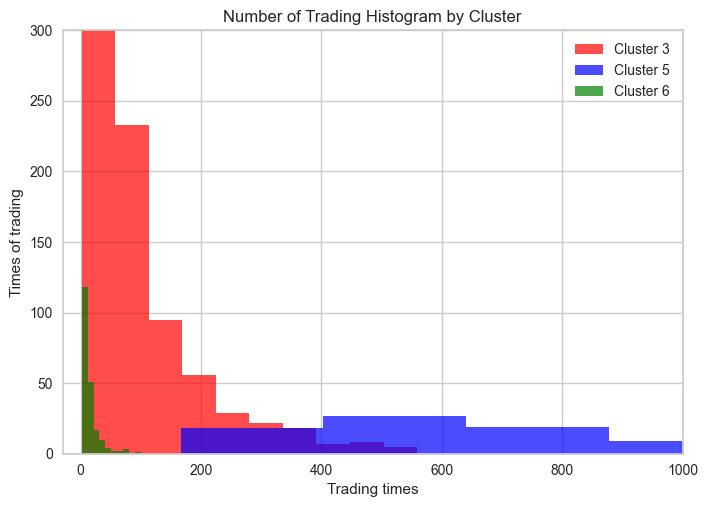

In [124]:
plt.hist(cluster_0['Number of trading'],color = "red",alpha = 0.7,label='Cluster 3')
#plt.hist(cluster_1['Number of trading'],color = "orange")
plt.hist(cluster_2['Number of trading'],color = "blue",alpha = 0.7,label='Cluster 5')
plt.hist(cluster_3['Number of trading'],color = "green",alpha = 0.7,label='Cluster 6')

plt.title("Number of Trading Histogram by Cluster")
plt.xlabel("Trading times")
plt.ylabel("Times of trading")
plt.legend()
plt.xlim([-30, 1000])
plt.ylim([0, 300])
plt.show()

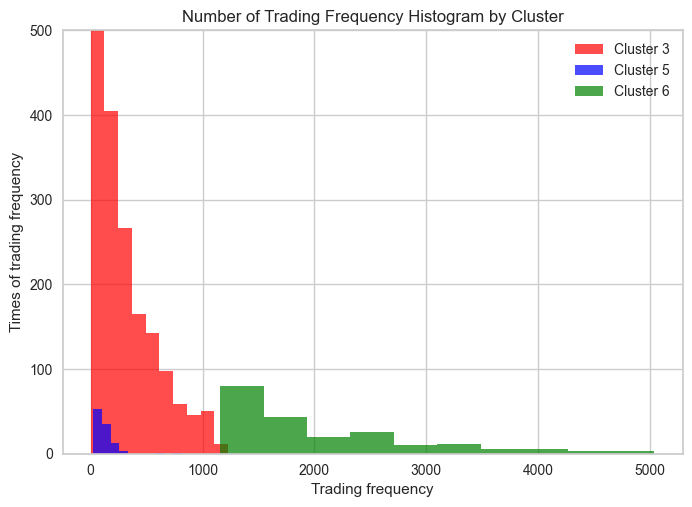

In [125]:
plt.hist(cluster_0['Trading frequency'],color = "red",alpha = 0.7,label='Cluster 3')
plt.hist(cluster_2['Trading frequency'],color = "blue",alpha = 0.7,label='Cluster 5')
plt.hist(cluster_3['Trading frequency'],color = "green",alpha = 0.7,label='Cluster 6')

plt.title("Number of Trading Frequency Histogram by Cluster")
plt.xlabel("Trading frequency")
plt.ylabel("Times of trading frequency")
plt.legend()
plt.ylim([0, 500])
plt.show()

In [ ]:
#------------------------------------------------------------------------------#

In [ ]:
len(set(trade_order_level_filled_sorted['symbol']))

In [ ]:
list(set(trade_order_level_filled_sorted['symbol']))

In [ ]:
wrong_symbol = []
symbol_sector = {}
for symbol in list(set(trade_order_level_filled_sorted['symbol'])):
    print(symbol)
    url = f'https://finance.yahoo.com/quote/{symbol}/profile/'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

    response = requests.get(url,headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    try:
        asset_profile_container = soup.find('div', class_='asset-profile-container')
        Sector = asset_profile_container.find('span', class_='Fw(600)').get_text()
        symbol_sector[symbol] = Sector
    except AttributeError:
        wrong_symbol.append(symbol)
        print("error in " + symbol)
        
'''
symbol_sector['BF.B'] = 'Consumer Defensive'
symbol_sector['TTCF'] = 'Consumer Defensive'
symbol_sector['BRK.B'] = 'Financial Services'
symbol_sector['TWTR'] = 'Communication Services'
'''

In [ ]:
#with open('symbol_sector.json', 'w') as file:
#    json.dump(symbol_sector, file)

In [36]:
with open('symbol_sector.json', 'r') as file:
    symbol_sector = json.load(file)